## XGBoost 

- XGBoost (eXtreme Gradient Boost) is an enhanced form of the gradient boosting machine learning model that combines weaker models (usuaully decision trees) together and subsequently trained in succesion with each iteration focusing on correcting the errors of the previous. 

- Unlike regular gradient boosting, XGBoost integrates L1 and L2 regularization and more sophisticated tree pruning (over and underfitting prevention) as well as parallel processing making this model perform well with larger datasets (highly scalable).

In [121]:
## All the libraries for XGBoost:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Splitting training and test data
from sklearn.model_selection import train_test_split

#For creating training pipeline and XGboost classification tasks
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

#Tuning model using BayesSearchCV and passing optimizer range of values to try
from skopt import BayesSearchCV
from skopt.space import Real, Integer

#Specific XGBoost plots
from skopt.plots import plot_convergence
from xgboost import plot_importance

#ROC Multiclass plot
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

#Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


#Pip installs:
#XGboost
#scikit-optimize

df = pd.read_csv("../../data/Student_performance_scaled.csv")  #follow the file structure provided

df.head()

,Age,Gender,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GradeClass
0,0.472919,0.978492,0.253711,1.780336,-0.890822,1.522371,-0.108744,-0.788476,-0.660132,2.019544,-0.431866,2.0
1,1.362944,-1.021981,-0.746087,0.997376,-1.717694,-0.656870,-0.999551,-0.788476,-0.660132,-0.495161,-0.431866,1.0
2,-1.307132,-1.021981,1.253509,-0.984045,1.353542,-0.656870,-0.108744,-0.788476,-0.660132,-0.495161,-0.431866,4.0
3,0.472919,0.978492,1.253509,0.045445,-0.063951,-0.656870,0.782063,1.268269,-0.660132,-0.495161,-0.431866,3.0
4,0.472919,0.978492,0.253711,-0.902311,0.290422,1.522371,0.782063,-0.788476,-0.660132,-0.495161,-0.431866,4.0


## Splitting Training and Test Data

In [122]:
#Seperate features from target
x= df.drop(columns='GradeClass')
y= df['GradeClass']

#Split x and y into training and test. 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, stratify= y, random_state= 8)

## Training Pipeline

- Pipelines streamline the preprocessing, model training, and evaluation.

In [123]:
#Create list of steps for pipline, setting random state ensures same results each run
estimators = [('clf', XGBClassifier(random_state=8))]

#Build pipeline from modeling steps (data preprocessing already done)
pipe = Pipeline(steps=estimators)

#Show built pipeline
pipe

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

## Hyperparameter Tuning

- These are a set of parameters that help fine tune and optimize the XGBoost model.

- Providing a range for each hyperparameter, BayesSearch can be utilised to find the optimal values for each of the hyperparameters.

In [124]:
#Search space used for defining hyperparams and setting ranges for optimization 
search_space = {
    'clf__learning_rate' : Real(0.01, 0.3, prior='log-uniform'),
    'clf__max_depth' : Integer(2, 20),
    'clf__min_child_weight': Integer(2, 20),
    'clf__gamma' : Real(0, 5),
    'clf__subsample' : Real(0.5, 1),
    'clf__colsample_bytree' : Real(0.5, 1)
}

#Using BayesSearchCV to optimize hyperparams in set ranges
opt =  BayesSearchCV(pipe, search_space, cv= 5, n_iter= 30, scoring= 'roc_auc_ovr', random_state=8)

## XGBoost Model Training

In [125]:
#Trains model and finds optimized hyperparams
opt.fit(x_train, y_train)

BayesSearchCV(cv=5,
              estimator=Pipeline(steps=[('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature_types=None,
                                                       feature_weights=None,
                                                       gamma=None,
                                                       grow_policy=None,
                                                       importance_type=None,
                                                       int...
                             'clf__gamma': Real(low=0, high=5, prior='uniform', transform='normalize'),
                             'clf__learning_rate': Real(low=0.01, high=0.3, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'clf__min_child_weight': Integer(low=2, high=20, prior='uniform', transform='normalize'),
                             'clf__subsample': Real(low=0.5, high=1, prior='uniform', transform='normalize')})

## Evaluate Model for Predictions

- The training and test scores (based on roc_auc_ovr metrics) are promising as both are close to the value of 1 and are close to each other.

- The convergence plot shows gradual improvement through each evaluation until a stable solution was found (plateau).


In [126]:
#Shows the pipeline instance with best hyperparam combinations
opt.best_estimator_

Pipeline(steps=[('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.6196797174258538, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, feature_weights=None,
                               gamma=1.397974264105447, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.07290439339954771, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=5,
                               max_leaves=None, min_child_weight=2, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [127]:
#Shows best CV (cross-validation) score from roc_auc_ovr during training
opt.best_score_

np.float64(0.8639678913723451)

In [128]:
#Shows final models score on test data
opt.score(x_test, y_test)

np.float64(0.8960179911698638)

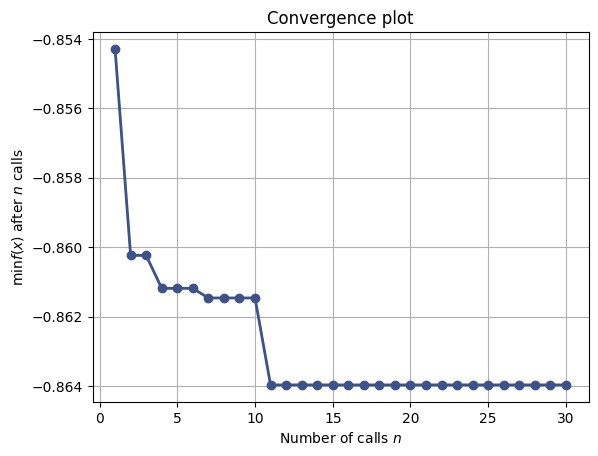

In [129]:
#Covergence plot based on BayesSearch optimum results
plot_convergence(opt.optimizer_results_) 
plt.savefig('../../artifacts/plots/XGB_Convergence_Plot.png')

## Analyzing Feature Performance

Best parameters: OrderedDict([('clf__colsample_bytree', 0.6196797174258538), ('clf__gamma', 1.397974264105447), ('clf__learning_rate', 0.07290439339954771), ('clf__max_depth', 5), ('clf__min_child_weight', 2), ('clf__subsample', 0.9986568297352434)])

Accuracy: 0.7244258872651357

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.24      0.38        21
         1.0       0.53      0.52      0.52        54
         2.0       0.55      0.64      0.59        78
         3.0       0.54      0.45      0.49        83
         4.0       0.87      0.93      0.90       243

    accuracy                           0.72       479
   macro avg       0.70      0.56      0.58       479
weighted avg       0.73      0.72      0.71       479



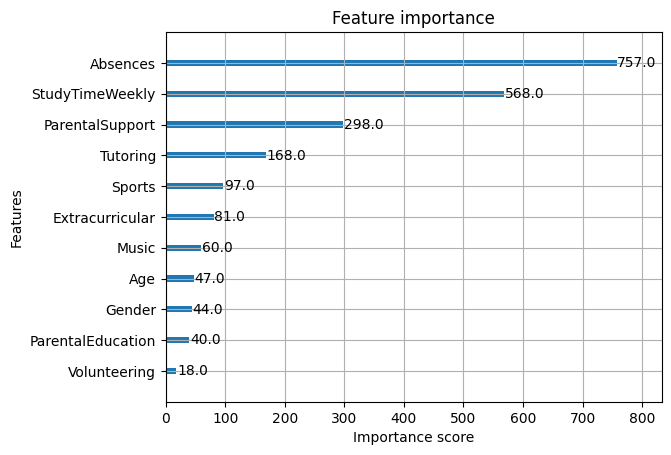

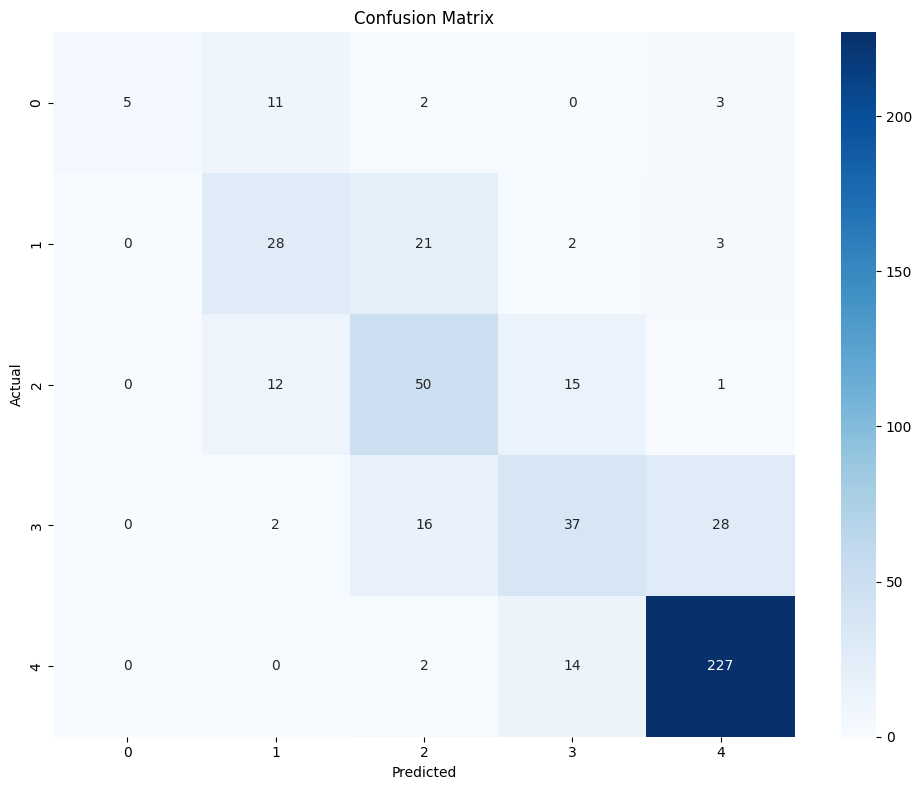

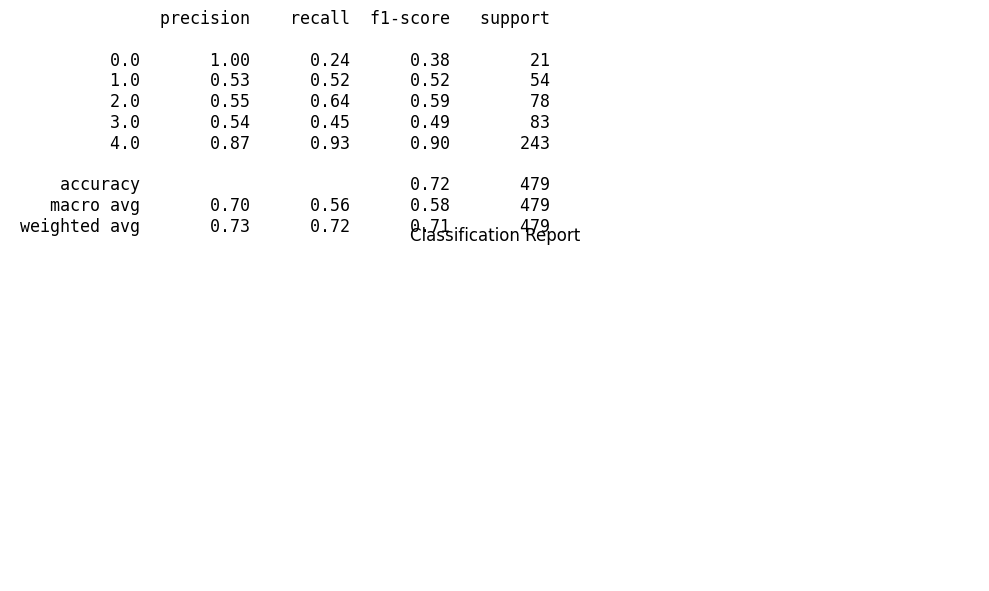

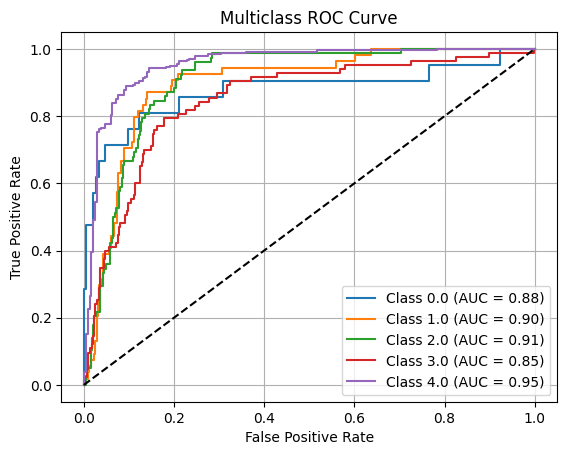

In [130]:
#Get the optimal pipeline steps (tuples)
xgboost_step = opt.best_estimator_.steps[0]

#Get trained model from tuple
xgboost_model = xgboost_step[1]

#Make predictions
y_pred = xgboost_model.predict(x_test)

#Optimized hyperparams
print("Best parameters:", opt.best_params_)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Feature performance (contribution to predictions)
plot_importance(xgboost_model)
plt.savefig('../../artifacts/plots/XGB_feature_importance.png')

# Confusion matrix plot
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('../../artifacts/plots/XGB_confusion_matrix.png')

#Classification Report
plt.figure(figsize=(10, 6))
plt.title('Classification Report')
plt.text(0.01, 0.99, classification_report(y_test, y_pred), {'fontsize': 12}, fontfamily='monospace')
plt.axis('off')
plt.tight_layout()
plt.savefig('../../artifacts/plots/XGB_classification_report.png', bbox_inches='tight')

plt.show()

#ROC Plot
# Binarize your y labels
classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = opt.predict_proba(x_test)

# Plot ROC curve for each class
for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {classes[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.savefig('../../artifacts/plots/XGB_ROC_Curve.png')

## Interpretation

- Optimized Hyperparameters:

    * clf__colsample_bytree: ~0.619
        62% of features used per tree, promotes generalization for the many features.

    * clf__gamma: ~1.397
        More conservative value, reduces overfitting by pruning especiallly weak splits. Promotes regularization.

    * clf__learning_rate: ~0.0729
        Slower learning rate, but stable performance. Improves generalization.

    * clf__max_depth: 5
        Limits max tree complexity. Lower depth leads to more simple models, promotes generalization.

    * clf__min_child_weight: 2
        Slight split restriction on low-sample nodes. Avoids overfitting as a result of healthy splits.

    * clf__subsample: ~0.998
        High value, small amount of randomness added. Neutral effect.

- Accuracy, Classification Report, and Confusion Matrix:
    72.4% accurate model. However, we notice some problems in each class:

    * Class 0:  Has a low recall, but high percision. This class could benefit from class weighting.

    * Class 1-2:
    The model struggles to seperate these classes and gets confuses them. Some features may overlap.

    * Class 3: Demonstrates some confusion between other classes, 4 especially. More data or feature analysis may help.

    * Class 4: Very well classified class.

    
- ROC Curve:
    * A good model is represented by values in the top left portion (True Positive Rate (TPR)) with each AUC (Area Under Curve) being close to 1.0.

## Saving Artifacts

In [131]:
import pickle

#Save predictions to CSV
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
predictions_df.to_csv('../../artifacts/predictions/XGB_predictions.csv', index=False)

#Save model as .pkl
with open('../../artifacts/models/XGB_model.pkl', 'wb') as f:
    pickle.dump(xgboost_model, f)